In [6]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications 
from tensorflow.keras.layers import Dense, Conv1D , GlobalAveragePooling2D , Dropout, MaxPooling1D, BatchNormalization, Flatten
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
import PIL
from PIL import Image
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import glob
import random

Get Dataset

In [7]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 95% 584M/612M [00:02<00:00, 280MB/s]
100% 612M/612M [00:02<00:00, 220MB/s]


In [9]:
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

Add images to test sorted

In [10]:
os.chdir(r"/content")
def ignore_files(dir, files):
        return [f for f in files if os.path.isfile(os.path.join(dir, f))]
  
if os.path.isdir("Test_sorted") is False:
    shutil.copytree("Train", 
                    "Test_sorted",
                    ignore=ignore_files)  

In [11]:
pth =r"/content/Test"
pth_sorted =r"/content/Test_sorted/"

dataframe1 = pd.read_csv(pth+'.csv')

folders = glob.glob(pth+"/*.png")

for path in folders:
    shutil.copy(path, pth_sorted+dataframe1[dataframe1['Path'] == 'Test/'+path[-9:]]['ClassId'].to_string(index = False))
    pass

Examine data imbalance and add augmented data

In [12]:
os.chdir(r"/content")
path_train = r'/content/Train'
#path_valid = r'/content/Valid'
path_test = r'/content/Test_sorted'

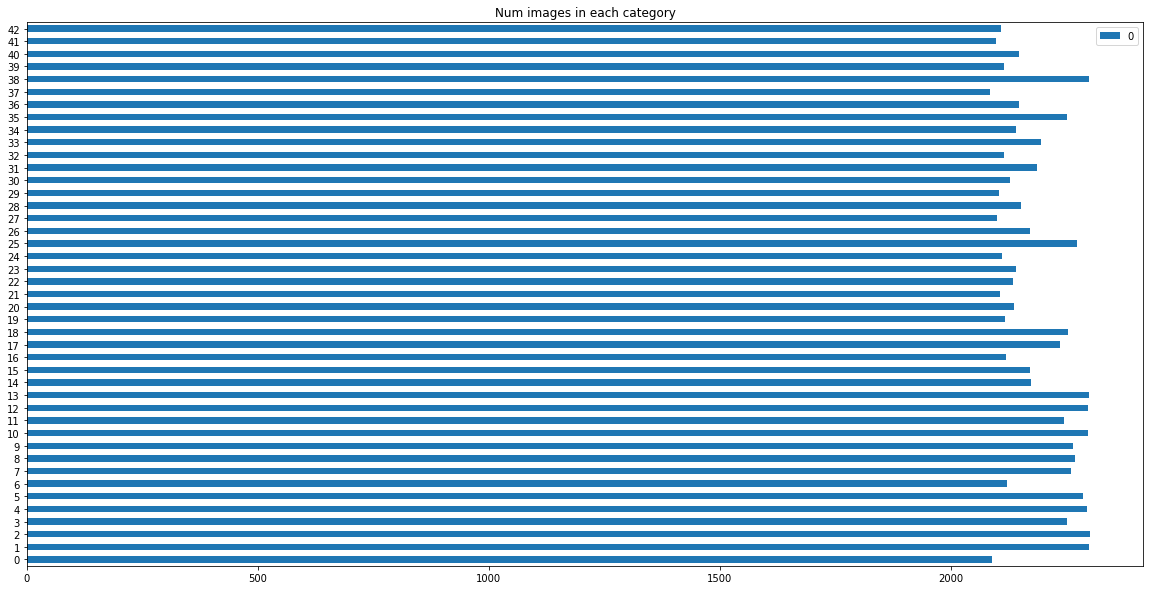

In [47]:
import collections
folders = glob.glob(path_train+"/*")
file_dir = {}
for path in folders:
    file_dir[int(os.path.basename(path))] = len(os.listdir(path))
 
file_df = pd.DataFrame(file_dir.values(), file_dir.keys()).sort_index()
file_df.plot(kind='barh', figsize=(20, 10), title='Num images in each category').figure.savefig('Num images in each category')

In [16]:
pth = r'/content/Train'

datagen = ImageDataGenerator(
    rotation_range = 30,
    zoom_range = 0.2,
    shear_range = 0.2,
    height_shift_range = 0.2, 
    brightness_range=[0.5, 1.5]) 

folders = glob.glob(pth+"/*")

for path in folders:
    i = 0
    #print(os.path.basename(path))
    num_new = 2300 - file_dir[os.path.basename(path)]
    #num_new = 10
    #print(num_new)
    while True:
        for f1 in random.sample(glob.glob(path+"/*"),1):
            i += 1
            #print(i)
            #print(num_new)
            img = Image.open(f1)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            next(datagen.flow(x, batch_size=1, shuffle=True, save_to_dir =path,save_prefix="a",save_format='png'))
        if i > num_new:
                break

In [17]:
datagen = ImageDataGenerator(
    rotation_range = 30,
    zoom_range = 0.2,
    shear_range = 0.2,
    height_shift_range = 0.2,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2)
train_batch = datagen.flow_from_directory(directory=path_train, class_mode='categorical', target_size=(224,224), color_mode = 'rgb', shuffle=True, batch_size = 10, subset='training')
valid_batch = datagen.flow_from_directory(directory=path_train, class_mode='categorical', target_size=(224,224), color_mode = 'rgb', shuffle=True, batch_size = 10, subset='validation')
test_batch = datagen.flow_from_directory(directory=path_test, class_mode='categorical', target_size=(224,224), batch_size = 10)

Found 75295 images belonging to 43 classes.
Found 18805 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


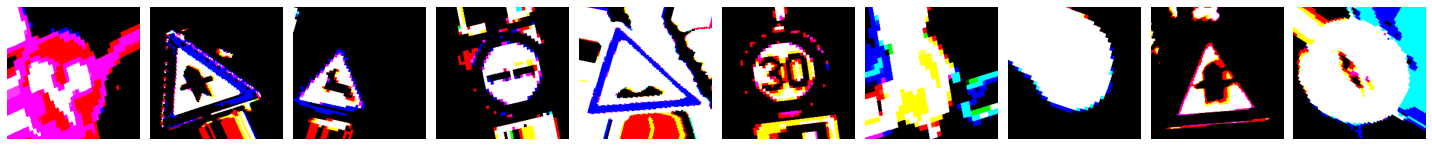

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [18]:
imgs, labels = next(train_batch)

def plotImages(im_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( im_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [48]:
vgg16_model = tf.keras.applications.vgg16.VGG16(weights="imagenet")

In [49]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [50]:
model = Sequential()
for layer in vgg16_model.layers[:-4]:
    model.add(layer)

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [52]:
for layer in model.layers:
    layer.trainable = False

In [24]:
#L2 reg

In [53]:
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(units=1024, activation='relu', kernel_regularizer = L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1024, activation='relu', kernel_regularizer = L2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=43, activation='softmax'))

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [55]:
metric=[CategoricalAccuracy(), Precision(), Recall(), AUC()]

In [56]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics= metric)

In [57]:
history = model.fit(x=train_batch, validation_data=valid_batch, steps_per_epoch = train_batch.samples // 10 , validation_steps = valid_batch.samples // 10, epochs=8 , verbose=2)

Epoch 1/8
7529/7529 - 961s - loss: 9.3998 - categorical_accuracy: 0.5437 - precision_1: 0.8070 - recall_1: 0.3909 - auc_1: 0.9589 - val_loss: 3.4742 - val_categorical_accuracy: 0.5972 - val_precision_1: 0.7891 - val_recall_1: 0.4810 - val_auc_1: 0.9691 - 961s/epoch - 128ms/step
Epoch 2/8
7529/7529 - 951s - loss: 2.9271 - categorical_accuracy: 0.6290 - precision_1: 0.8392 - recall_1: 0.4809 - auc_1: 0.9763 - val_loss: 2.7051 - val_categorical_accuracy: 0.6176 - val_precision_1: 0.8054 - val_recall_1: 0.5040 - val_auc_1: 0.9746 - 951s/epoch - 126ms/step
Epoch 3/8
7529/7529 - 954s - loss: 2.5271 - categorical_accuracy: 0.6528 - precision_1: 0.8489 - recall_1: 0.5130 - auc_1: 0.9795 - val_loss: 2.4933 - val_categorical_accuracy: 0.6426 - val_precision_1: 0.8108 - val_recall_1: 0.5339 - val_auc_1: 0.9752 - 954s/epoch - 127ms/step
Epoch 4/8


KeyboardInterrupt: ignored

In [30]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_precision', 'val_recall', 'val_auc'])


In [31]:
print(history.history['val_loss'])

[1.536691427230835, 1.464852213859558, 1.4819186925888062, 1.4371241331100464, 1.4368540048599243, 1.3754569292068481, 1.4591505527496338, 1.3962262868881226]


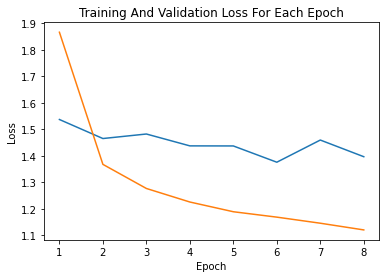

In [43]:
epochs = [1,2,3,4,5,6,7,8]
val_loss = history.history['val_loss']
train_loss = history.history['loss']

fig = plt.figure()
ax = plt.axes()
ax.plot(epochs, val_loss);
ax.plot(epochs, train_loss);
ax.set(title = 'Training And Validation Loss For Each Epoch', xlabel='Epoch', ylabel='Loss' )
ax.figure.savefig('Training And Validation Loss For Each Epoch')

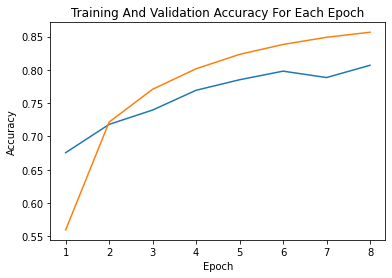

In [44]:
val_accuracy = history.history['val_categorical_accuracy']
train_accuracy = history.history['categorical_accuracy']

fig = plt.figure()
ax = plt.axes()
ax.plot(epochs, val_accuracy);
ax.plot(epochs, train_accuracy);
ax.set(title = 'Training And Validation Accuracy For Each Epoch', xlabel='Epoch', ylabel='Accuracy')
ax.figure.savefig('Training And Validation Accuracy For Each Epoch')

In [35]:
predictions = model.predict(x=test_batch, verbose = 2)

1263/1263 - 128s - 128s/epoch - 101ms/step


In [36]:
test_results = model.evaluate(test_batch)

1263/1263 [==============================] - 131s 103ms/step - loss: 1.7944 - categorical_accuracy: 0.7271 - precision: 0.7947 - recall: 0.6947 - auc: 0.9630


In [37]:
test_results

[1.7944036722183228,
 0.727078378200531,
 0.7947463989257812,
 0.6946951746940613,
 0.9630396366119385]

In [38]:
x = ['Loss', 'Categorical Accuracy', 'Precision', 'Recall', 'AUC']

pd.DataFrame(test_results, index = x)

,0
Loss,1.794404
Categorical Accuracy,0.727078
Precision,0.794746
Recall,0.694695
AUC,0.963040


In [45]:
model.save('models/road_sign_model1.h5')